In [1]:
import numpy as np
import scipy as sp
import scanpy as sc
import anndata as ad
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
PLT_CELL = 3.5

In [24]:
X = pd.read_csv('../data/Renge/X_renge_d2_80.csv', index_col=0)
E = pd.read_csv('../data/Renge/E_renge_d2_80.csv', index_col=0)

In [3]:
adata = sc.read_h5ad('../data/Renge/hipsc.h5ad')
adata

AnnData object with n_obs × n_vars = 4013 × 103
    obs: 't', 'ko'
    var: 'gene', 'type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [12]:
selected_genes = [
    "MYC", "TCF7L1", "ZNF398", "UBTF", "NR5A2", "DNMT1", "MED1", "KDM5B",
    "TCF3", "SALL4", "CHD7", "CTNNB1", "JARID2", "FOXH1", "NANOG",
    "SOX2", "PRDM14", "POU5F1",
]
gene_strings = adata.var["gene"].astype(str)  

missing = [g for g in selected_genes if g not in gene_strings.values]
if missing:
    raise ValueError(f"These genes weren’t found in adata.var['gene']: {missing}")

adata.var_names = gene_strings
adata.var_names_make_unique() 

adata18 = adata[:, selected_genes].copy()

valid_targets  = set(selected_genes)
is_panel_ko    = adata18.obs["ko"].isin(valid_targets)

adata_sub = adata18[is_panel_ko, :].copy()
print(f"Retaining {adata_sub.n_obs} cells out of {adata.n_obs}")

Retaining 3022 cells out of 4013


In [13]:
adata_sub

AnnData object with n_obs × n_vars = 3022 × 18
    obs: 't', 'ko'
    var: 'gene', 'type', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [14]:
adata.obs['ko']

barcode
ATCTACTCAAGTAATG-1_0     POU5F1
CGGTTAATCTAGAGTC-1_0     PRDM14
TTCTACAGTGCACCAC-1_0     POU5F1
GATTCAGCAGACGTAG-1_0      NANOG
TACGGTATCGAGAGCA-1_0     PRDM14
                         ...   
TGACTAGAGCTGTCTA-1_3      NANOG
GCTGGGTCACTGTCGG-1_3       ZIC2
GCTCCTATCACAAACC-1_3    RUNX1T1
GATCTAGCACCGTTGG-1_3       SOX2
CACACCTCATTGGTAC-1_3      NANOG
Name: ko, Length: 4013, dtype: category
Categories (8, object): ['MYC', 'NANOG', 'POU5F1', 'PRDM14', 'RUNX1T1', 'SOX2', 'ZIC2', 'ZIC3']

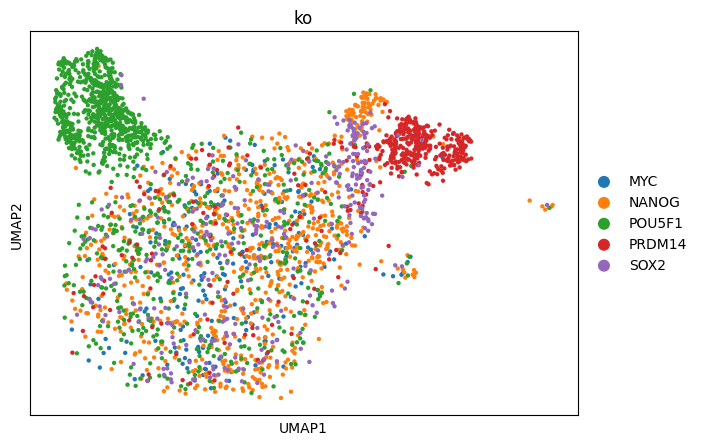

In [6]:
sc.pl.scatter(adata_sub, basis = "umap", color = "ko")

In [7]:
import glob
# Construct reference 
refs = {}
for f in glob.glob("../data/Renge/chip_1kb/*.tsv"):
    gene = os.path.splitext(os.path.basename(f))[0].split(".")[0]
    df = pd.read_csv(f, sep = "\t")
    df.index = df.Target_genes
    # if len(df.columns[df.columns.str.contains("iPS_cells|ES_cells")]) == 0:
    #     print(pd.unique(df.columns.str.split("|").str[1]))
    y = pd.Series(df.loc[:, df.columns.str.contains("iPS_cells")].values.mean(-1), index = df.index)
    # y = pd.Series(df.iloc[:, 2:].values.mean(-1), index = df.index) 
    # y = pd.Series(df.iloc[:, 1], index = df.index) 
    refs[gene] = y

/tmp/ipykernel_4110658/3603932205.py:10: RuntimeWarning: Mean of empty slice.
  y = pd.Series(df.loc[:, df.columns.str.contains("iPS_cells")].values.mean(-1), index = df.index)
/home/noahe162/miniconda3/envs/sf2m/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_4110658/3603932205.py:10: RuntimeWarning: Mean of empty slice.
  y = pd.Series(df.loc[:, df.columns.str.contains("iPS_cells")].values.mean(-1), index = df.index)
/home/noahe162/miniconda3/envs/sf2m/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_4110658/3603932205.py:10: RuntimeWarning: Mean of empty slice.
  y = pd.Series(df.loc[:, df.columns.str.contains("iPS_cells")].values.mean(-1), index = df.index)
/home/noahe162/miniconda3/envs/sf2m/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encounte

In [8]:
A_ref = pd.DataFrame(refs).T
A_ref[np.isnan(A_ref.values)] = 0

In [19]:
_kos = ['POU5F1', 'PRDM14', 'NANOG', 'SOX2', 'MYC'][::-1]
_kos

['MYC', 'SOX2', 'NANOG', 'PRDM14', 'POU5F1']

/home/noahe162/miniconda3/envs/sf2m/lib/python3.11/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


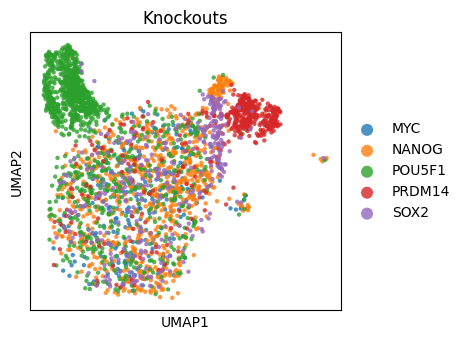

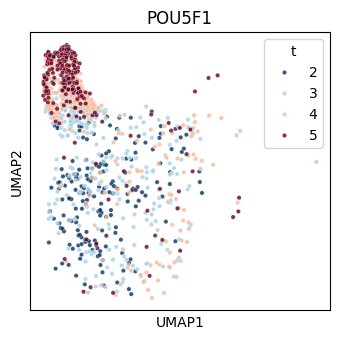

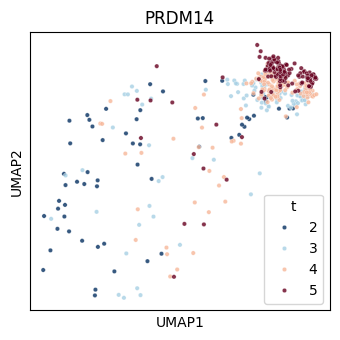

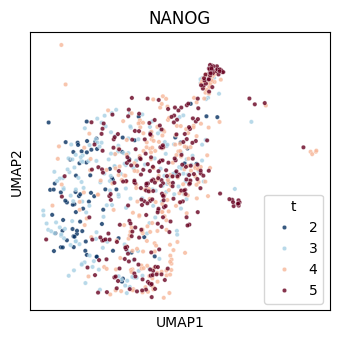

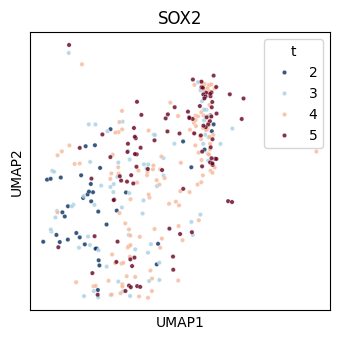

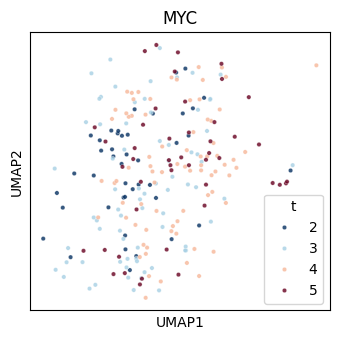

In [20]:
_adata = adata_sub[adata_sub.obs['ko'].isin(_kos), :]

fig, ax = plt.subplots(1, 1, figsize=(1.36*PLT_CELL, PLT_CELL))
sc.pl.scatter(_adata, basis = "umap", color = "ko", show = False, ax = ax, alpha = 0.8)
plt.title("Knockouts")
plt.tight_layout()
plt.savefig("scCRISPR_knockouts_umap.pdf")
for g in ["POU5F1", "PRDM14", "NANOG", "SOX2", "MYC"]:
    fig, ax = plt.subplots(1, 1, figsize=(PLT_CELL, PLT_CELL))
    sb.scatterplot(x = _adata[_adata.obs.ko == g, :].obsm["X_umap"][:, 0], 
                   y = _adata[_adata.obs.ko == g, :].obsm["X_umap"][:, 1], 
                   hue = _adata[_adata.obs.ko == g].obs.t, palette="RdBu_r", alpha = 0.8, s = 10)
    plt.title(f"{g}")
    plt.xlabel("UMAP1"); plt.ylabel("UMAP2")
    plt.xticks([], []); plt.yticks([], [])
    plt.tight_layout()
    plt.savefig(f"scCRISPR_{g}_umap.pdf")

In [25]:
adata_tf = adata_sub.copy()
print(adata_tf.var.gene)
mask = adata_tf.var.gene.isin(E.columns)
adata_tf = adata_tf[:, mask].copy()
adata_tf.var.index = adata_tf.var.gene

gene
MYC          MYC
TCF7L1    TCF7L1
ZNF398    ZNF398
UBTF        UBTF
NR5A2      NR5A2
DNMT1      DNMT1
MED1        MED1
KDM5B      KDM5B
TCF3        TCF3
SALL4      SALL4
CHD7        CHD7
CTNNB1    CTNNB1
JARID2    JARID2
FOXH1      FOXH1
NANOG      NANOG
SOX2        SOX2
PRDM14    PRDM14
POU5F1    POU5F1
Name: gene, dtype: category
Categories (18, object): ['CHD7', 'CTNNB1', 'DNMT1', 'FOXH1', ..., 'TCF3', 'TCF7L1', 'UBTF', 'ZNF398']


In [21]:
import sys
sys.path.append("../src/models/components")
import importlib
import rf #type: ignore[import]
importlib.reload(rf)
import torch

In [29]:
options = {
    "lr" : 0.1,
    "reg_sinkhorn" : 0.05,
    "reg_A" : 0.5e-3, 
    "reg_A_elastic" : 0.5,
    "iter" : 1_000,
    "ot_coupling" : True,
    "optimizer" : torch.optim.Adam,
    "n_pca_components" : 50
}

In [30]:
_adatas = []
for k in _kos:
    _adatas.append(adata_tf[adata_tf.obs.ko == k, :].copy())
    _adatas[-1].X = np.asarray(_adatas[-1].X.todense(), dtype = np.float64)
    _adatas[-1].obs.t -= 2
    _adatas[-1].var.index = _adatas[-1].var.gene
if _kos[0] == "WT":
    _kos[0] = None

In [31]:
estim_alt = rf.Estimator(_adatas, _kos, 
                           lr = options["lr"],
                           reg_sinkhorn = options["reg_sinkhorn"], 
                           reg_A = options["reg_A"], 
                           reg_A_elastic = options["reg_A_elastic"], 
                           iter = options["iter"], 
                           ot_coupling = options["ot_coupling"],
                           optimizer = options["optimizer"], 
                          n_pca_components = options["n_pca_components"])
estim_alt.fit(print_iter=100, alg = "alternating", update_couplings_iter=500);

/home/noahe162/sf2m-grn-hydra/notebooks/../src/models/components/rf.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(self.A, requires_grad=True, dtype=torch.float64)
/home/noahe162/sf2m-grn-hydra/notebooks/../src/models/components/rf.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(self.b, requires_grad=True, dtype=torch.float64)


Updating transport plans
iteration 0, loss = 1.1844655876829604, L = 1.1844655876829604, R = 0.0
iteration 100, loss = 0.08493441770697034, L = 0.07529799315839077, R = 19.272849097159153
iteration 200, loss = 0.08440275695701167, L = 0.07458689442567171, R = 19.631725062679944
iteration 300, loss = 0.08438443315523075, L = 0.07458595755733133, R = 19.59695119579886
iteration 400, loss = 0.08439890181081508, L = 0.07454889382587135, R = 19.700015969887477
iteration 500, loss = 0.6911972055831108, L = 0.6813455019744818, R = 19.70340721725788
iteration 600, loss = 0.016069374169646114, L = -0.012996817963109164, R = 58.13238426551055
iteration 700, loss = 0.012672499147295024, L = -0.016809787015577317, R = 58.96457232574468
iteration 800, loss = 0.011787897428607006, L = -0.01786327886964272, R = 59.302352596499446
iteration 900, loss = 0.011416788152527748, L = -0.018315232584041975, R = 59.464041473139446


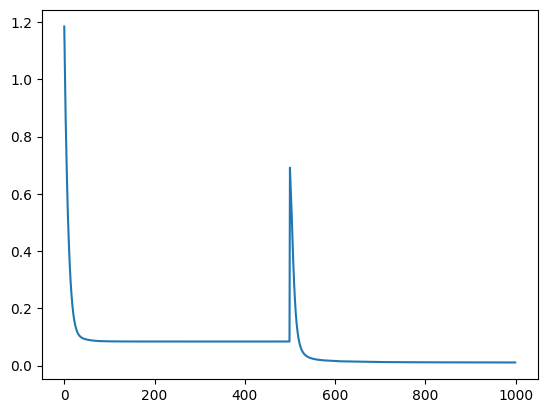

In [32]:
plt.plot(estim_alt.trace)

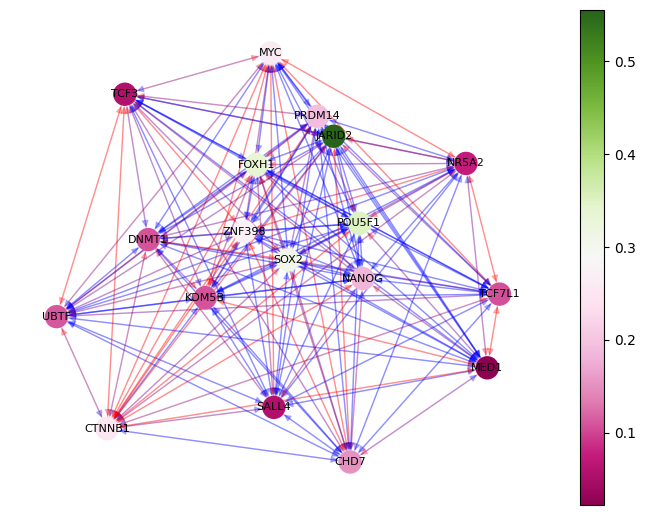

In [33]:
A = pd.DataFrame(np.asarray(estim_alt.A.clone()), index = adata_tf.var.index, columns = adata_tf.var.index)
import networkx as nx

g = nx.DiGraph(np.abs(A))
centralities = nx.centrality.eigenvector_centrality(g.reverse(), weight = 'weight') # calcualte first centrality without thresholding

thresh = np.quantile(np.abs(A.values), 0)
A[np.abs(A) <= thresh] = 0
g = nx.DiGraph(A)
g = nx.subgraph(g, max(nx.connected_components(nx.Graph(g)), key=len))

edge_colors = ['blue' if g[u][v]['weight'] > 0 else 'red' for u, v in g.edges()]

np.random.seed(42)
# nx.draw_nodes(g, with_labels = True, node_color = [centralities[x] for x in g.nodes], edge_color = edge_colors, node_size = 250, font_size = 8, cmap = "PiYG", pos=nx.shell_layout(g),)
pos = nx.spring_layout(g, iterations=250, k = 5)
plt.figure(figsize = (2*PLT_CELL, 1.5*PLT_CELL))
pc = nx.draw_networkx_nodes(g, node_color = [centralities[x] for x in g.nodes], node_size = 250, cmap = "PiYG", pos=pos)
plt.colorbar(pc)
nx.draw_networkx_labels(g, pos=pos, font_size=8);
nx.draw_networkx_edges(g, edge_color=edge_colors, pos = pos, alpha = 0.25);
plt.axis("off")
plt.tight_layout()
plt.savefig("./scCRISPR_net_graph.pdf")

/tmp/ipykernel_4110658/18864677.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_tick_labels);


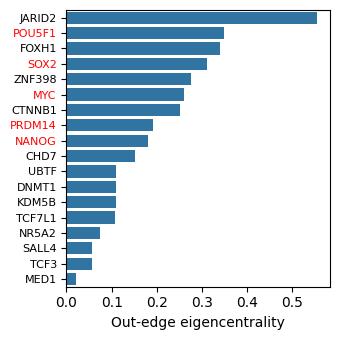

In [34]:
A = pd.DataFrame(np.asarray(estim_alt.A.clone()), index = adata_tf.var.index, columns = adata_tf.var.index)
g = nx.DiGraph(np.abs(A))
centralities = nx.centrality.eigenvector_centrality(g.reverse(), weight = 'weight') # calcualte first centrality without thresholding
_centralities = pd.Series(centralities)
plt.figure(figsize = (PLT_CELL, PLT_CELL))
sb.barplot(_centralities.sort_values()[::-1][:25], orient = 'h')
plt.yticks(fontsize=8);
ax = plt.gca()
y_ticks = ax.get_yticks()
y_tick_labels = ax.get_yticklabels()
for label in y_tick_labels:
    if label.get_text() in _kos:
        label.set_color('red')
ax.set_yticklabels(y_tick_labels);
plt.xlabel("Out-edge eigencentrality")
plt.tight_layout()
plt.savefig("./scCRISPR_centrality.pdf")

In [35]:
A_renge = pd.read_csv("../data/Renge/A_renge_output.csv", index_col=0)

In [36]:
genes_common = pd.Index(set(A_ref.columns).intersection(set(A.index)))
tfs = A_ref.index
tfs_no_ko = [i for i in tfs if i not in _kos]
tfs_ko = [i for i in tfs if i in _kos]

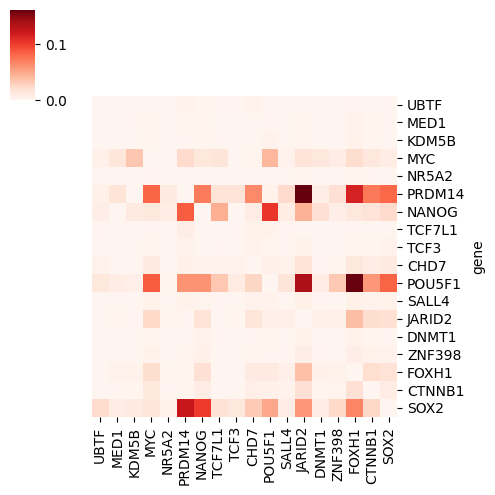

In [37]:
common = list(pd.Index(tfs).intersection(genes_common))  # ONE ordered list
A_sub  = A_renge.loc[common, common]                          # rows = cols

cg = sb.clustermap(A_sub.abs(), cmap="Reds", figsize=(5, 5),
                   row_cluster=False, col_cluster=False)

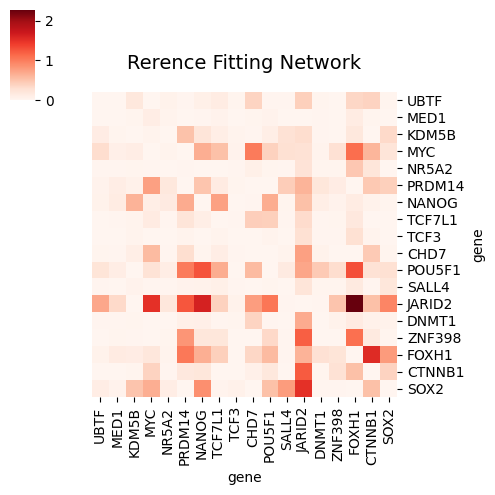

In [38]:
_A = pd.DataFrame(estim_alt.A, index = adata_tf.var.index, columns=adata_tf.var.index)
threshold = np.quantile(_A.values, 0)
_A[_A < threshold] = 0
cg = sb.clustermap(_A.loc[common, common].abs(), figsize = (5, 5), row_cluster = False, cmap="Reds", col_cluster= False)
cg.ax_heatmap.set_title("Rerence Fitting Network", fontsize=14, pad=16)
plt.savefig("RF_heatmap.pdf")

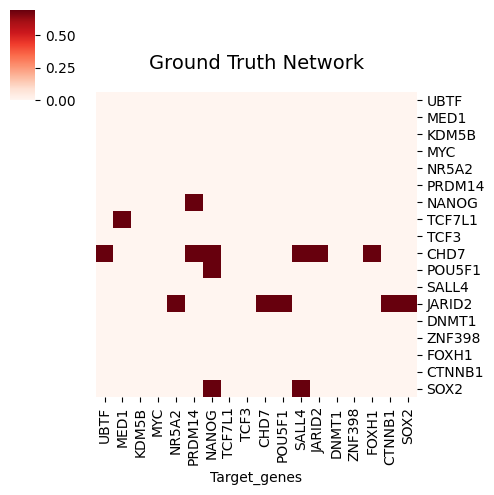

In [39]:
_thresh = 0
A_ground_truth = A_ref.loc[common, common]

A_plot = np.log1p(A_ground_truth > _thresh)  

reference = sb.clustermap(
    A_plot,
    figsize=(5, 5),
    cmap="Reds",
    row_cluster=False,
    col_cluster=False
)
reference.ax_heatmap.set_title("Ground Truth Network", fontsize=14, pad=16)
plt.show()

In [58]:
A = pd.read_csv('../W_v_sf2m__mix:False_1_ogsetting.csv', header=0, index_col=0)
A = A.copy()
np.fill_diagonal(A.values, 0)

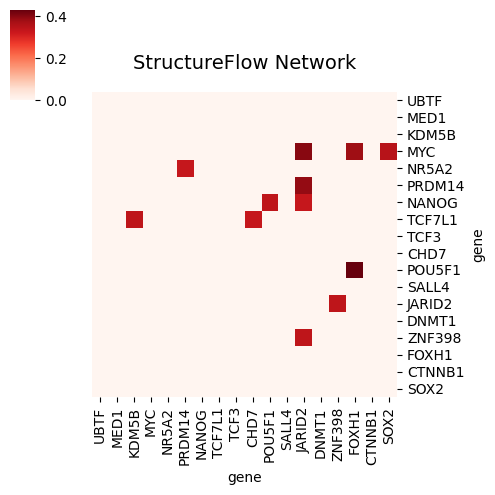

In [59]:
A = pd.DataFrame(A, index = adata_tf.var.index, columns=adata_tf.var.index)
threshold = np.quantile(A.values, 0)
A[A < threshold] = 0
cg = sb.clustermap(A.loc[common, common].abs(), figsize = (5, 5), row_cluster = False, cmap="Reds", col_cluster= False)
cg.ax_heatmap.set_title("StructureFlow Network", fontsize=14, pad=16)
plt.savefig("StructureFlow_heatmap.pdf")

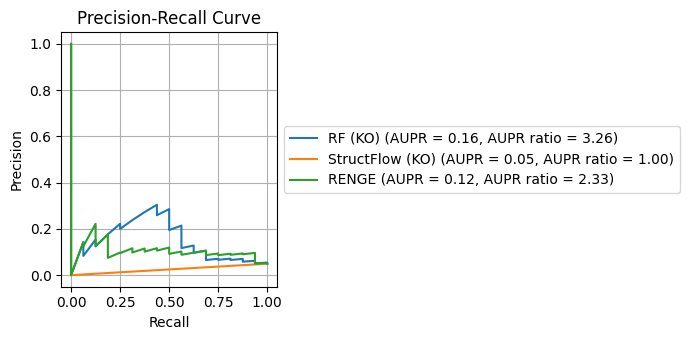

In [60]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score
ys = {}
y_true = (A_ref.loc[common, common] > _thresh).values.flatten()
ys["RF (KO)"] = np.abs(_A.loc[common, common]).values.flatten()
ys["StructFlow (KO)"] = np.abs(A.loc[common, common]).values.flatten()
ys["RENGE"] = np.abs(A_renge.loc[common, common]).values.flatten()

plt.figure(figsize = (2*PLT_CELL, PLT_CELL))
for (k, y) in ys.items():
    prec, rec, thresh = precision_recall_curve(y_true, y)
    avg_prec = average_precision_score(y_true, y)
    plt.plot(rec, prec, label=f'{k} (AUPR = {avg_prec:.2f}, AUPR ratio = {avg_prec / y_true.mean():.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.savefig("scCRISPR_AUPR.pdf")